In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm  
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
df = pd.read_csv("full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [4]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


In [11]:
print(len(cataract),len(normal))

594 500


In [12]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "C:/Users/MCA/Desktop/preprocess"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [13]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:02<00:00, 228.01it/s]


In [14]:
len(dataset)

588

In [15]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:02<00:00, 210.83it/s]


In [16]:
len(dataset)

1088

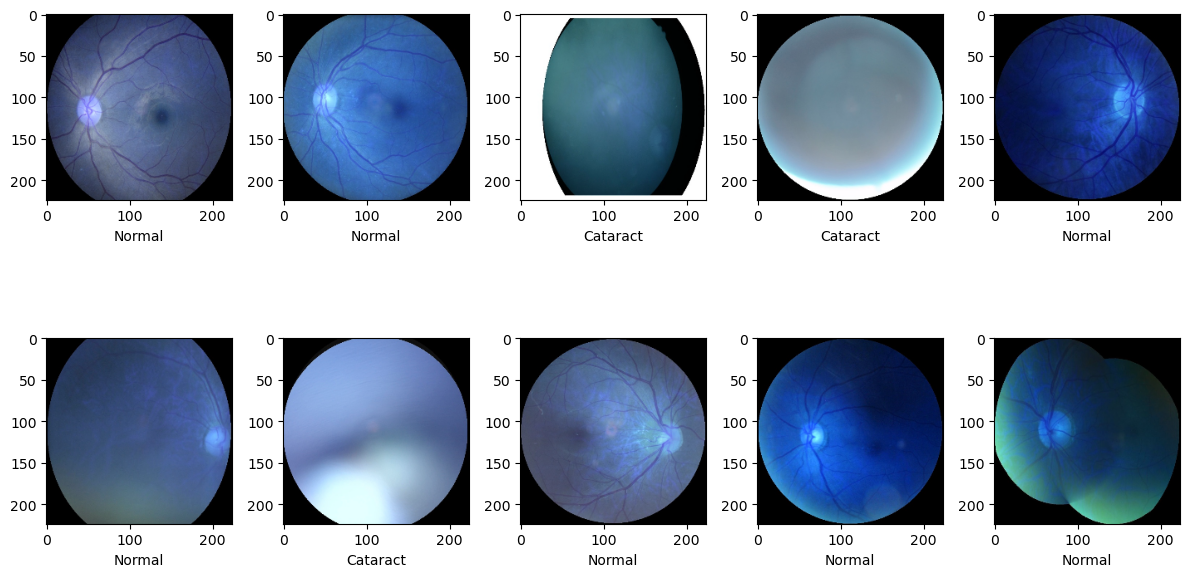

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the AlexNet model
def create_alexnet(input_shape):
    model = Sequential()
    
    # First convolutional layer
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Third convolutional layer
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Fourth convolutional layer
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Fifth convolutional layer
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))  # Change the number of classes as needed

    return model

# Create the AlexNet model
image_size = 224  # Set your desired image size
alexnet = create_alexnet(input_shape=(image_size, image_size, 3))


In [21]:
# Assuming the AlexNet model is already defined as shown previously

# Compile the AlexNet model
alexnet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint("alexnet.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False)

# Create EarlyStopping callback
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the AlexNet model for binary classification
def create_alexnet(input_shape):
    model = Sequential()
    
    # First convolutional layer
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Third convolutional layer
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Fourth convolutional layer
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Fifth convolutional layer
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
    # Change the output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))  # Single output for binary classification

    return model

# Create the AlexNet model for binary classification
image_size = 224  # Set your desired image size
alexnet = create_alexnet(input_shape=(image_size, image_size, 3))

# Compile the model
alexnet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [24]:
history = alexnet.fit(
    x_train, 
    y_train, 
    batch_size=32, 
    epochs=5, 
    validation_data=(x_test, y_test), 
    verbose=1, 
    callbacks=[checkpoint, earlystop]
)

Epoch 1/5
28/28 [==============================] - ETA: 0s - loss: 48.0613 - accuracy: 0.5414
Epoch 1: val_accuracy improved from -inf to 0.48624, saving model to alexnet.h5
28/28 [==============================] - 74s 3s/step - loss: 48.0613 - accuracy: 0.5414 - val_loss: 0.6823 - val_accuracy: 0.4862
Epoch 2/5
28/28 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5621
Epoch 2: val_accuracy improved from 0.48624 to 0.66055, saving model to alexnet.h5
28/28 [==============================] - 56s 2s/step - loss: 0.6841 - accuracy: 0.5621 - val_loss: 0.6366 - val_accuracy: 0.6606
Epoch 3/5
28/28 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7172
Epoch 3: val_accuracy improved from 0.66055 to 0.74312, saving model to alexnet.h5
28/28 [==============================] - 60s 2s/step - loss: 0.5679 - accuracy: 0.7172 - val_loss: 0.4960 - val_accuracy: 0.7431
Epoch 4/5
28/28 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 

In [25]:
# Evaluate the AlexNet model on the test data
loss, accuracy = alexnet.evaluate(x_test, y_test)

# Print the results
print("Loss:", loss)
print("Accuracy:", accuracy)

7/7 [==============================] - 2s 286ms/step - loss: 0.5284 - accuracy: 0.7706
Loss: 0.5283529758453369
Accuracy: 0.7706422209739685


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Assuming 'alexnet' is your trained AlexNet model
raw_predictions = alexnet.predict(x_test)

# For binary classification, convert probabilities to binary class labels
y_pred = (raw_predictions > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1

# Assuming y_test is also in binary format (0 or 1)
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Accuracy:", accuracy)


7/7 [==============================] - 2s 290ms/step
Confusion Matrix:
 [[76 37]
 [13 92]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.67      0.75       113
           1       0.71      0.88      0.79       105

    accuracy                           0.77       218
   macro avg       0.78      0.77      0.77       218
weighted avg       0.79      0.77      0.77       218

Accuracy: 0.7706422018348624
